# Fritz's Bandpass Filter impulse response calculation from scattering paramter s21

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf

In [2]:
#import the .s2p file
filter_by_fritz = rf.Network(r"fritz_filter_longitudinal.s2p")

In [3]:
f = filter_by_fritz.frequency.f
f_min = f[0]
f_step = 305e3
f_max = f[-1]
f_interp = np.arange(f_step,f_max,f_step)

# raw complex frequency response H(jw)=s21
s21_raw = filter_by_fritz.s[:,1,0]

In [4]:
#interpolate such that f_min=f_step. This is not necessary. I did it to not being forced to interpolated between f_min and DC at multiple points
s21_real_interp = np.interp(f_interp,f,s21_raw.real)
s21_imag_interp = np.interp(f_interp,f,s21_raw.imag)

In [5]:
s21_interp = s21_real_interp + 1j*s21_imag_interp

In [6]:
#DC extrapolation keeping the frequency response hermitian: H*(jw)=H(-jw)
f_extrapolated_dc = np.hstack((0,f_interp))
s21_real_extrapolated_dc = np.hstack((s21_real_interp[0],s21_real_interp))
s21_imag_extrapolated_dc = np.hstack((0,s21_imag_interp))

In [7]:
# adding negative frequency part to the frequency response. This way the frequency response is hermitian: H*(jw)=H(-jw)
s21_real_extrapolated_dc=np.hstack((s21_real_extrapolated_dc,np.flip(s21_real_extrapolated_dc)))
s21_real_extrapolated_dc=np.fft.fftshift(s21_real_extrapolated_dc)

s21_imag_extrapolated_dc=np.hstack((s21_imag_extrapolated_dc,-np.flip(s21_imag_extrapolated_dc)))
s21_imag_extrapolated_dc=np.fft.fftshift(s21_imag_extrapolated_dc)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [9]:
def my_fft(data, sample_rate=10):
    fftSize = len(data)
    spectrum = np.fft.fft(data)
    freq = np.fft.fftfreq(fftSize, 1/sample_rate)
    return (freq, spectrum)

def my_ifft(spectrum, sample_rate=10):
   # freq = np.fft.fftfreq(fftSize, 1/sample_rate)
    return np.fft.ifft(spectrum)

def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )

In [10]:
Nparts, Nturns =  1500, 20000
betPU, alfPU       =  1.3, -0.9
betK, alfK         =  0.8,  0.6
gamPU, gamK        =  (1 + alfPU**2)/betPU, (1 + alfK**2)/betK
muPUK, muKPU       =  1.51, 2*np.pi*1.34 - 1.51
total_angle        =  2*np.pi*1.34
etaPUK, etaKPU     =  -0.01, -0.01    #eta PUK must be reletevely small, so they dont change slices so fast... 0.02 breaks the system ... It is the limit case!!!! very sensitive on etaPUK --> 2 much unwanted mixing, also etaKPU cant go very low(limit case 0.3) because then the mixing is bad
sigdelt            =   5.74e-7          # rms momentum spread in unit
Th, Trev           =  .1e-6, 5.0e-6, # half width of simulation window and revolution period in s
Tovlap, NSamp, add = 4*sigdelt*abs(etaPUK + etaKPU)*Trev, 800, '2000'
gain               =  0.0001  #as long as I reduce the eta, i have to reduce gains as well... see book
gainL              =  8e-7

DTSamp   = Th/NSamp

In [11]:
band_start_Hz = 0.8e9
band_end_Hz = 1.6e9

wlL, wrL = -1.6e-9, 1.6e-9
def respL( Dt ):
    #if Dt < 1.*wlL or Dt > 1.*wrL:
     #   print( f' ===> function respL called with Dt ={1e6*Dt:8.4f}' )
    return ((63e9*Dt)*(1 - 6.5e18*Dt**2)*(1 - 1.55e18*Dt**2)*(1 - (.625e9*Dt)**2)**8)/18

n_f_points = 1000


time_axis_response = np.linspace(wlL, wrL, n_f_points)

# Evaluate the response on this clean axis
response_signal_clean = respL(time_axis_response)

spectrum_response = np.fft.fftshift(np.fft.fft(response_signal_clean))
freqs_response = np.fft.fftshift(np.fft.fftfreq(len(response_signal_clean), d=(time_axis_response[1] - time_axis_response[0])))

frequency_evaluation_Hz = np.linspace(-2*band_end_Hz, 2*band_end_Hz, int(n_f_points)+1)
print('len(frequency_evaluation',len(frequency_evaluation_Hz))
print('diafora frequency_evaluation',frequency_evaluation_Hz[1]-frequency_evaluation_Hz[0])
print('lin result:', len(frequency_evaluation_Hz) / (frequency_evaluation_Hz[1] - frequency_evaluation_Hz[0]))
# reshaffle to be ifft-compatible
frequency_evaluation_Hz = np.concatenate([frequency_evaluation_Hz[int(n_f_points/2):], frequency_evaluation_Hz[0:int(n_f_points/2)]])
# compute equivalent time axis
time_evaluation_s = np.linspace(0, 1, len(frequency_evaluation_Hz))/(frequency_evaluation_Hz[1]-frequency_evaluation_Hz[0])

dt = 1 / (time_evaluation_s[1] - time_evaluation_s[0])


# Generate 30 points before 0
extra_time = np.linspace(-time_evaluation_s[30], 0, 30)

# Prepend them to the time axis
time_evaluation_s = np.concatenate((extra_time, time_evaluation_s))
response_signal = respL(time_evaluation_s)
print('DTSamp',DTSamp)
print('time_evaluation_s last',time_evaluation_s[60])
print('time_evaluation_s0',time_evaluation_s[0])
bin=time_evaluation_s[1]-time_evaluation_s[0]
samples=1.6e-9/bin
print('samples',samples)

(freq_signal,spectrum_signal)=my_fft(response_signal, 1/(time_evaluation_s[1]-time_evaluation_s[0]))

# create bandpass filter
b, a = signal.butter(5, (band_start_Hz, band_end_Hz), 'bandpass', analog=True)
# evaluate response in frequency domain
w, h = signal.freqs(b, a, worN=frequency_evaluation_Hz)
# go to time domain
time_evaluation_v = my_ifft(h)


# go back to the frequency domain, this time using the "real" part of the reconstructed time signal
time_evaluation_v_trimmed = np.copy(np.real(time_evaluation_v))
time_evaluation_v_trimmed[30:] = 0
time_evaluation_v_trimmed[0:30] = time_evaluation_v_trimmed[0:30] - np.mean(time_evaluation_v_trimmed[0:30])
time_evaluation_v_trimmed = np.concatenate((np.zeros(30), time_evaluation_v_trimmed))

(freq_new, spectrum_new) = my_fft(time_evaluation_v_trimmed, 1/(time_evaluation_s[1]-time_evaluation_s[0]))

#we did this for 30 points, i) i have to acually put the rest of the points(30, with the same time and number of points to 0 ii) I have to draw my response function and its fft on top of this)




len(frequency_evaluation 1001
diafora frequency_evaluation 6400000.0
lin result: 0.00015640625
DTSamp 1.2499999999999998e-10
time_evaluation_s last 4.6875e-09
time_evaluation_s0 -4.6875e-09
samples 9.898666666666665


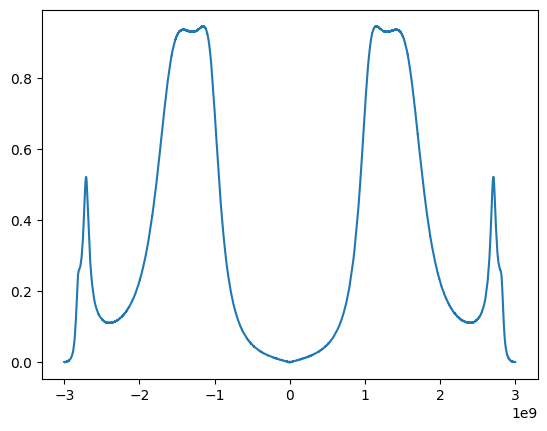

In [12]:
s21_extrapolated_dc = s21_real_extrapolated_dc+1j*s21_imag_extrapolated_dc

f_full_extrapolated_dc = np.hstack((-1*np.flip(f_extrapolated_dc),f_extrapolated_dc))
# check amplitude spectrum containing negative frequencies
plt.plot(f_full_extrapolated_dc,np.abs(s21_extrapolated_dc))

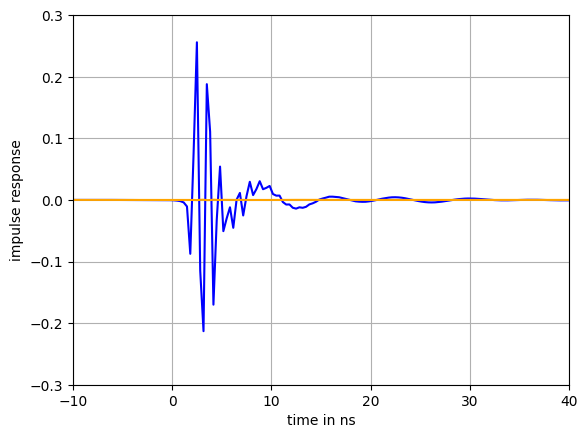

In [13]:
# compute and plot the impulse response on a linear scale
t = np.linspace(-1/f_extrapolated_dc[1],1/f_extrapolated_dc[1],2*len(f_extrapolated_dc))

impulse_response = np.fft.ifft(s21_extrapolated_dc)
impulse_response = np.fft.ifftshift(impulse_response)
plt.plot(t*1e9,np.real(impulse_response),"b")
plt.plot(t*1e9,np.imag(impulse_response),"orange")
plt.xlim([-10,40])
plt.ylim([-0.3,0.3])
plt.xlabel("time in ns")
plt.ylabel("impulse response")
plt.grid()

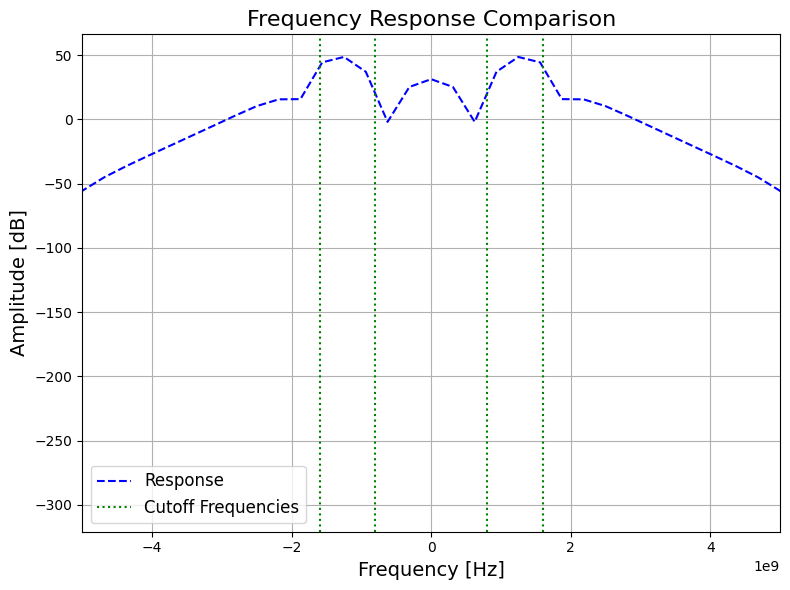

In [32]:
band_start_Hz = 0.8e9
band_end_Hz = 1.6e9

wlL, wrL = -1.6e-9, 1.6e-9
def respH( Dt ):
    #if Dt < 1.*wlL or Dt > 1.*wrL:
     #   print( f' ===> function respL called with Dt ={1e6*Dt:8.4f}' )
    return (1 - 27e18*Dt**2)*(1 - 3.e18*Dt**2)*(1 - 1.15e18*Dt**2)*(1 - (.625e9*Dt)**2)**7
n_f_points = 1000


time_axis_responseH = np.linspace(wlL, wrL, n_f_points)

# Evaluate the response on this clean axis
response_signal_cleanH = respH(time_axis_responseH)

spectrum_responseH = np.fft.fftshift(np.fft.fft(response_signal_cleanH))
freqs_responseH = np.fft.fftshift(np.fft.fftfreq(len(response_signal_cleanH), d=(time_axis_responseH[1] - time_axis_responseH[0])))
plt.figure(figsize=(8,6))

# Plot Butterworth filter spectrum in dB
#plt.plot(freq_new, 20 * np.log10(np.abs(spectrum_new)), 'r.', label='Butterworth')

# Plot system response spectrum in dB
plt.plot(freqs_responseH, 20 * np.log10(np.abs(spectrum_responseH)), 'b--', label='Response')

# Plot extrapolated DC filter spectrum in dB
#plt.plot(f_full_extrapolated_dc, 20 * np.log10(np.abs(s21_extrapolated_dc)), color='orange', label='Filter')

# Axis labels and title
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel('Amplitude [dB]', fontsize=14)
plt.title('Frequency Response Comparison', fontsize=16)

# Grid
plt.grid(which='both', axis='both')

# Add vertical lines at cutoff frequencies
plt.axvline(-band_start_Hz, color='green', linestyle=':', label='Cutoff Frequencies')
plt.axvline(-band_end_Hz, color='green', linestyle=':')
plt.axvline(band_start_Hz, color='green', linestyle=':')
plt.axvline(band_end_Hz, color='green', linestyle=':')

# Set x-axis limits
plt.xlim([-5e9, 5e9])

# Legend
plt.legend(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

(-1e-08, 2e-08)

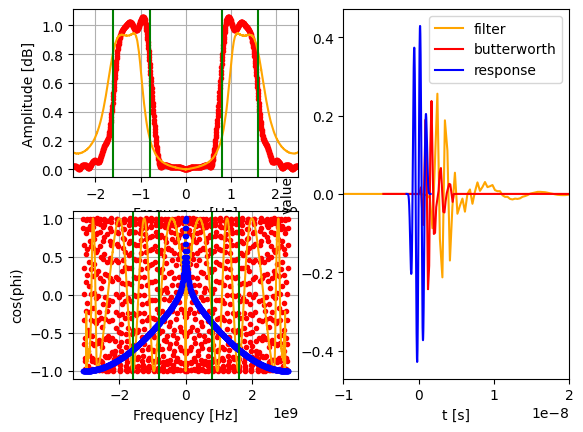

In [19]:
plt.subplot(2,2,1)
#plt.plot(w, 20 * np.log10(abs(h)), 'k.')
#plt.plot(w, np.abs(h), 'k.', label='Original')
plt.plot(freq_new, np.abs(spectrum_new), 'r.', label='butterworth')
#plt.plot(freq_signal, np.abs(spectrum_signal), 'b.', label='Signal')
#plt.plot(freqs_response, np.abs(spectrum_response), 'b--', label='response')  # Add this line
plt.plot(f_full_extrapolated_dc,np.abs(s21_extrapolated_dc),'orange', label='filter')  # Add this line
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')
plt.axvline(-band_start_Hz, color='green') # cutoff frequency
plt.axvline(-band_end_Hz, color='green') # cutoff frequency
plt.axvline(band_start_Hz, color='green') # cutoff frequency
plt.axvline(band_end_Hz, color='green') # cutoff frequency
#plt.xlim([band_start_Hz/10, band_end_Hz*10])
plt.xlim([-2.5e9, 2.5e9])

plt.subplot(2,2,3)
#plt.plot(w, np.cos(np.angle(h)), 'k.', label='Original')
plt.plot(freq_new, np.cos(np.angle(spectrum_new)), 'r.', label='butterworth')
plt.plot(f_full_extrapolated_dc,np.cos(np.angle(s21_extrapolated_dc)),'orange', label='filter')  # Add this line
plt.plot(freq_signal, np.cos(np.angle(spectrum_signal)), 'b.', label='Signal')
#plt.plot(freqs_response, np.cos(np.angle(spectrum_response)), 'b--', label='Response')  # Add this line
plt.xlabel('Frequency [Hz]')
plt.ylabel('cos(phi)')
plt.grid(which='both', axis='both')
plt.axvline(-band_start_Hz, color='green') # cutoff frequency
plt.axvline(-band_end_Hz, color='green') # cutoff frequency
plt.axvline(band_start_Hz, color='green') # cutoff frequency
plt.axvline(band_end_Hz, color='green') # cutoff frequency
#plt.xlim([band_start_Hz/10, band_end_Hz*10])

plt.subplot(1,2,2)
#plt.plot(time_evaluation_s, np.real(time_evaluation_v_trimmed), 'k.-', label='real')
#plt.plot(time_evaluation_s, np.imag(time_evaluation_v_trimmed), 'g.-', label='imag')
plt.plot(t,np.real(impulse_response),"orange", label='filter')
plt.plot(time_evaluation_s, time_evaluation_v_trimmed, 'r-', label='butterworth')
plt.plot(time_axis_response, response_signal_clean, 'b-', label='response')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('value')
#plt.xlim([-5*1.6e-9, 5*1.6e-9])
#plt.ylim([-0.05, 0.05])
#plt.xlim([band_start_Hz/10, band_end_Hz*10])
plt.xlim([-10e-9, 20e-9])


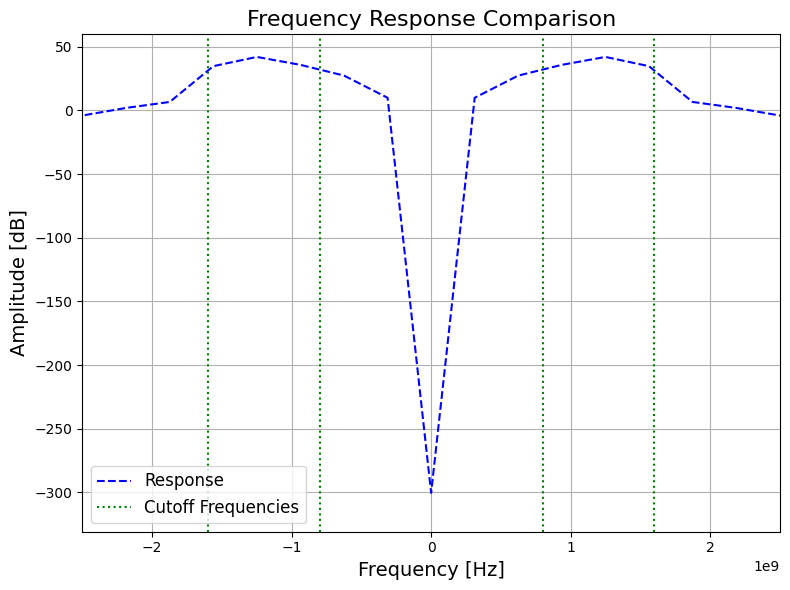

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Example placeholder data (remove when using your real variables)
# freq_new = np.linspace(-2.5e9, 2.5e9, 1000)
# spectrum_new = np.random.random(1000)
# freqs_response = freq_new
# spectrum_response = spectrum_new * 5  # Example with larger values
# f_full_extrapolated_dc = freq_new
# s21_extrapolated_dc = spectrum_new * 0.8
# band_start_Hz = 500e6
# band_end_Hz = 1.5e9

# Create a new figure
plt.figure(figsize=(8,6))

# Plot Butterworth filter spectrum in dB
#plt.plot(freq_new, 20 * np.log10(np.abs(spectrum_new)), 'r.', label='Butterworth')

# Plot system response spectrum in dB
plt.plot(freqs_response, 20 * np.log10(np.abs(spectrum_response)), 'b--', label='Response')

# Plot extrapolated DC filter spectrum in dB
#plt.plot(f_full_extrapolated_dc, 20 * np.log10(np.abs(s21_extrapolated_dc)), color='orange', label='Filter')

# Axis labels and title
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel('Amplitude [dB]', fontsize=14)
plt.title('Frequency Response Comparison', fontsize=16)

# Grid
plt.grid(which='both', axis='both')

# Add vertical lines at cutoff frequencies
plt.axvline(-band_start_Hz, color='green', linestyle=':', label='Cutoff Frequencies')
plt.axvline(-band_end_Hz, color='green', linestyle=':')
plt.axvline(band_start_Hz, color='green', linestyle=':')
plt.axvline(band_end_Hz, color='green', linestyle=':')

# Set x-axis limits
plt.xlim([-2.5e9, 2.5e9])

# Legend
plt.legend(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

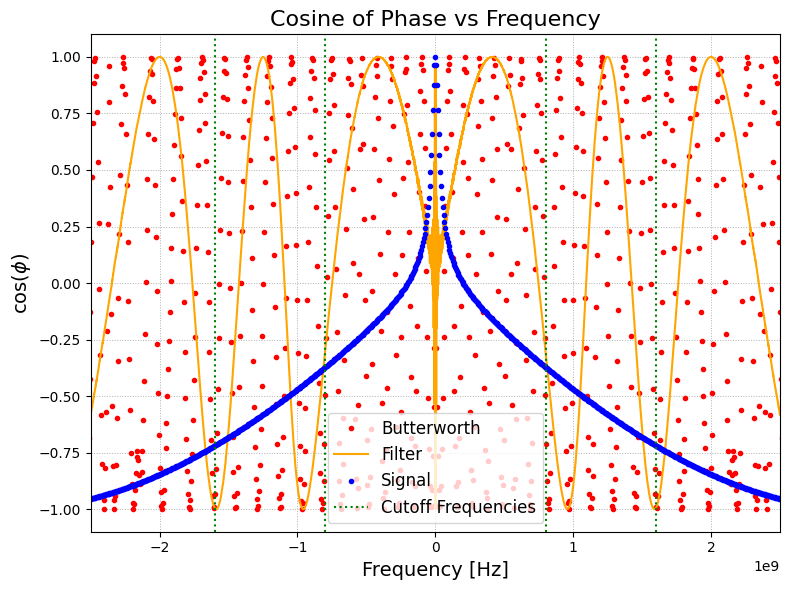

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Example placeholder data (remove when using your real variables)
# freq_new = np.linspace(-2.5e9, 2.5e9, 1000)
# spectrum_new = np.random.random(1000) + 1j * np.random.random(1000)
# f_full_extrapolated_dc = freq_new
# s21_extrapolated_dc = spectrum_new * 0.8
# freq_signal = freq_new
# spectrum_signal = spectrum_new * 0.9
# band_start_Hz = 500e6
# band_end_Hz = 1.5e9

# Create a new figure
plt.figure(figsize=(8,6))

# Plot Butterworth cos(phase)
plt.plot(freq_new, np.cos(np.angle(spectrum_new)), 'r.', label='Butterworth')

# Plot extrapolated DC filter cos(phase)
plt.plot(f_full_extrapolated_dc, np.cos(np.angle(s21_extrapolated_dc)), color='orange', label='Filter')

# Plot signal cos(phase)
plt.plot(freq_signal, np.cos(np.angle(spectrum_signal)), 'b.', label='Signal')

# Axis labels and title
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel(r'$\cos(\phi)$', fontsize=14)
plt.title('Cosine of Phase vs Frequency', fontsize=16)

# Grid
plt.grid(which='both', axis='both', linestyle=':', linewidth=0.7)

# Add vertical lines at cutoff frequencies
plt.axvline(-band_start_Hz, color='green', linestyle=':', label='Cutoff Frequencies')
plt.axvline(-band_end_Hz, color='green', linestyle=':')
plt.axvline(band_start_Hz, color='green', linestyle=':')
plt.axvline(band_end_Hz, color='green', linestyle=':')

# Set x-axis limits
plt.xlim([-2.5e9, 2.5e9])

# Legend
plt.legend(fontsize=12, loc='best')

# Tight layout
plt.tight_layout()

# Show plot
plt.show()

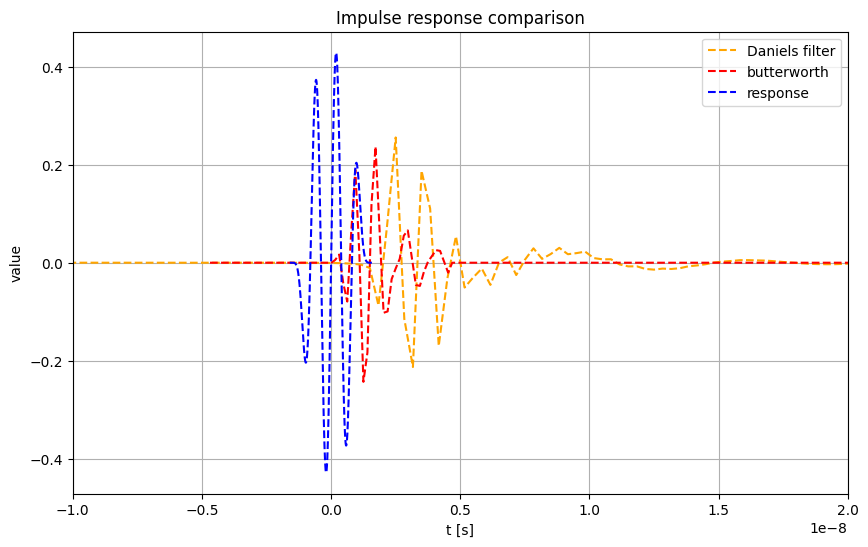

In [15]:
plt.figure(figsize=(10,6))  # Αλλάζεις και το μέγεθος του figure αν θες
#plt.plot(time_evaluation_s, np.real(time_evaluation_v_trimmed), 'k.-', label='real')
#plt.plot(time_evaluation_s, np.imag(time_evaluation_v_trimmed), 'g.-', label='imag')
plt.plot(t,np.real(impulse_response),"orange",linestyle='--', label='Daniel''s filter')
plt.plot(time_evaluation_s, time_evaluation_v_trimmed, 'r--', label='butterworth')
plt.plot(time_axis_response, response_signal_clean, 'b--', label='response')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('value')
plt.xlim([-10e-9, 20e-9])
plt.grid(True)
plt.title("Impulse response comparison")
plt.show()

As can be seen in the next plot of the impulse response in dB, the impulse response is not zero before t=0. Sample value of -60 dB and lower before t=0 seems causal enough for me.

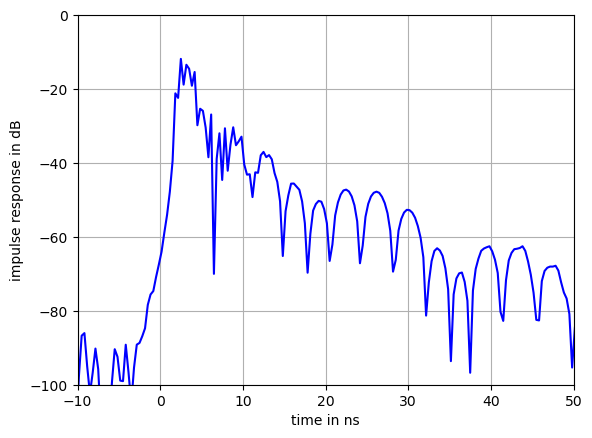

In [550]:
# plot the impulse response on a dB scale
plt.plot(t*1e9,20*np.log10(np.abs(np.real(impulse_response))),"b")
plt.xlim([-10,50])
plt.ylim([-100,0])
plt.xlabel("time in ns")
plt.ylabel("impulse response in dB")
plt.grid()

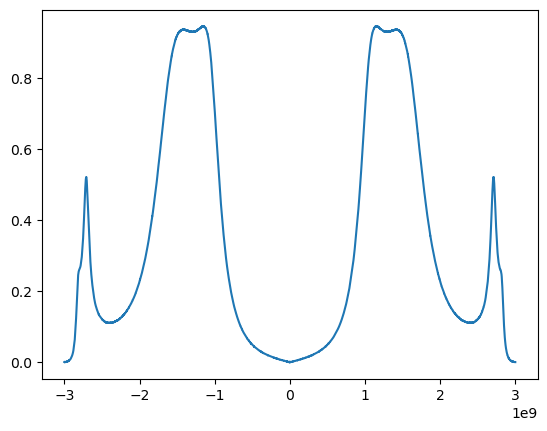

In [551]:
# check the spectrum of the fft of the computed impulse response
plt.plot(f_full_extrapolated_dc,(np.abs(np.fft.ifft(impulse_response))*2*len(f_extrapolated_dc)))

In [23]:
initial=0.002117
final=0.00388



(final-initial)/initial *100

83.27822390174777